# 03 - Interactive Viz

## Introduction 
TODO

['', '/home/lemni/anaconda3/lib/python36.zip', '/home/lemni/anaconda3/lib/python3.6', '/home/lemni/anaconda3/lib/python3.6/lib-dynload', '/home/lemni/anaconda3/lib/python3.6/site-packages', '/home/lemni/anaconda3/lib/python3.6/site-packages/Sphinx-1.5.6-py3.6.egg', '/home/lemni/anaconda3/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg', '/home/lemni/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/lemni/.ipython']


In [3]:
#import and constants
import folium
import os
import pandas as pd
import json
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
DATAPATH = "./03-Interactive_Viz/data/"

In [2]:
folium.__version__ == '0.5.0'

True

[Link to folium documentation](https://folium.readthedocs.io/en/latest/quickstart.html#geojson-topojson-overlays)

## Question 1

* First chose the database [here](http://ec.europa.eu/eurostat/data/database)
    * There are many choices. Maybe the one under General regionl statistics - European and national indicators for short-term analysis - Larbour market called Harmonized unemployment rate
    * Justify our choice, get the method of computation of the figures (ratio of unemployment over employment + unemployment, between 15 -77 ans ...) 
    * Get the last data, either the last month with full data, the last month and complete missing values with older one, take a whole year instead of a month..
    * Justify the previous actions 
* Show the data on the map
    * Justify the colors, the steps..
    * Set value for countries not on the data (andorra) that are in EU, maybe another value for other countries not in UE (switzerland..)
* Compare figure with Switzerland 
    * How ? 
* Add interactions in order to make the visualization intuitive and expressive
* Analyze results

TODO : explain how I get the file

## Question 2

* Get the data [here](https://www.amstat.ch/v2/index.jsp?lang=fr), maybe explain how and why
* Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

* The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization. 

* Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.


In [5]:
#First let's check the topojson file
canton_json_path = os.path.join(DATAPATH,"topojson","ch-cantons.topojson.json")
canton_json_data = json.load(open(canton_json_path))
print(canton_json_data['objects']['cantons']['geometries'])

[{'type': 'Polygon', 'arcs': [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], 'id': 'ZH', 'properties': {'name': 'Zürich'}}, {'type': 'MultiPolygon', 'arcs': [[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], [23], [24]], [[25, 26]], [[27]], [[28, 29]]], 'id': 'BE', 'properties': {'name': 'Bern/Berne'}}, {'type': 'Polygon', 'arcs': [[-12, 30, 31, 32, 33, 34]], 'id': 'LU', 'properties': {'name': 'Luzern'}}, {'type': 'Polygon', 'arcs': [[35, 36, 37, 38, -16, 39, 40, 41]], 'id': 'UR', 'properties': {'name': 'Uri'}}, {'type': 'Polygon', 'arcs': [[42, -33, 43, -1, 44, 45, 46, -42]], 'id': 'SZ', 'properties': {'name': 'Schwyz'}}, {'type': 'MultiPolygon', 'arcs': [[[-13, -35, 47]], [[-15, 48, -40]]], 'id': 'OW', 'properties': {'name': 'Obwalden'}}, {'type': 'Polygon', 'arcs': [[-34, -43, -41, -49, -14, -48]], 'id': 'NW', 'properties': {'name': 'Nidwalden'}}, {'type': 'Polygon', 'arcs': [[49, -36, -47, 50, 51]], 'id': 'GL', 'properties': {'name': 'Glarus'}}, {'type': 'Polygon', 'arcs': [[-32, 52, -2, -4

To get the csv file, we went on the amstat website and then into Details. We chose "Chômeurs et demandeurs d'emploi", "taux de chômage" and export a csv file containing the unemployment ratio, the figures linked to unemployed people (we also add the young and long-term ones), we also select "Demandeurs d'emplois" (people looking for a job) and "Demandeurs d'emplois non chômeurs" (people with a job looking for a new one).
TODO : description of cleaning of the file

In [6]:
# Then let's import the csv file 
# Note that well implemented websites should also work under firefox. To be easier I've set the data in git
swiss_df = pd.read_csv(os.path.join(DATAPATH,"chomage_suisse.csv")) # TODO, load and clean
swiss_df.head()

,Cantons,Taux de chômage,Coefficients de variation,Chômeurs inscrits,Chômeurs jeunes,Chômeurs de longue durée,Demandeurs d'emploi,Demandeurs d'emploi non chômeurs
0,Zurich,3.3,A,27225,3420,4753,34156,6931
1,Berne,2.4,A,13658,2003,2336,18385,4727
2,Lucerne,1.7,A,3885,664,453,6756,2871
3,Uri,0.6,C,112,15,13,257,145
4,Schwyz,1.7,A,1455,185,189,2229,774


We can notice some differences between the canton's names in both sides.

In [7]:
json_swiss_names = [(i['id'],i['properties']['name']) for i in canton_json_data['objects']['cantons']['geometries']]
for (json,df) in zip(json_swiss_names,swiss_df['Cantons']):
    print(json,df)

print('Json length : {} , csv length : {}'.format(len(json_swiss_names),swiss_df.shape[0]))

('ZH', 'Zürich') Zurich
('BE', 'Bern/Berne') Berne
('LU', 'Luzern') Lucerne
('UR', 'Uri') Uri
('SZ', 'Schwyz') Schwyz
('OW', 'Obwalden') Obwald
('NW', 'Nidwalden') Nidwald
('GL', 'Glarus') Glaris
('ZG', 'Zug') Zoug
('FR', 'Fribourg') Fribourg
('SO', 'Solothurn') Soleure
('BS', 'Basel-Stadt') Bâle-Ville
('BL', 'Basel-Landschaft') Bâle-Campagne
('SH', 'Schaffhausen') Schaffhouse
('AR', 'Appenzell Ausserrhoden') Appenzell Rhodes-Extérieures
('AI', 'Appenzell Innerrhoden') Appenzell Rhodes-Intérieures
('SG', 'St. Gallen') St-Gall
('GR', 'Graubünden/Grigioni') Grisons
('AG', 'Aargau') Argovie
('TG', 'Thurgau') Thurgovie
('TI', 'Ticino') Tessin
('VD', 'Vaud') Vaud
('VS', 'Valais/Wallis') Valais
('NE', 'Neuchâtel') Neuchâtel
('GE', 'Genève') Genève
('JU', 'Jura') Jura
Json length : 26 , csv length : 27


Luckily the tuple Id,name in json match perfectly with the dataFrame, excepting the `Total` row that is useless here. 
We will just add the ID property to our dataframe without any treatment (it's already matching) and remove the last row

In [8]:
#Note that we could have reused previous variable but we have chosen to recompute it for clarity
cantons_ids = [i['id'] for i in canton_json_data['objects']['cantons']['geometries']]
if swiss_df.shape[0]>26:#We add this condition to avoid any error when running the cell twice
    no_tot_swiss_df = swiss_df.drop(26)#We remove the Total row
no_tot_swiss_df = no_tot_swiss_df.assign(canton_id=cantons_ids)

Now we will show these data on the swiss map. 
We will first show the swiss Map without our overlay and then create it. 
We chose to center with some coordinates that seemed weel suited for our visualization 

In [9]:
#TODO : Change tiles property
m_switzerland = folium.Map([46.8,8], tiles='Mapbox Bright', zoom_start=8)
m_switzerland

<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxoZWFkPiAgICAKICAgIDxtZXRhIGh0dHAtZXF1aXY9ImNvbnRlbnQtdHlwZSIgY29udGVudD0idGV4dC9odG1sOyBjaGFyc2V0PVVURi04IiAvPgogICAgPHNjcmlwdD5MX1BSRUZFUl9DQU5WQVMgPSBmYWxzZTsgTF9OT19UT1VDSCA9IGZhbHNlOyBMX0RJU0FCTEVfM0QgPSBmYWxzZTs8L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2Nkbi5qc2RlbGl2ci5uZXQvbnBtL2xlYWZsZXRAMS4yLjAvZGlzdC9sZWFmbGV0LmpzIj48L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2FqYXguZ29vZ2xlYXBpcy5jb20vYWpheC9saWJzL2pxdWVyeS8xLjExLjEvanF1ZXJ5Lm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvanMvYm9vdHN0cmFwLm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuanMiPjwvc2NyaXB0PgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL2Nkbi5qc2RlbGl2ci5uZXQvbnBtL2xlYWZsZXRAMS4yLjAvZGlzdC9sZWFmbGV0LmNzcyIgLz4KICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvY3NzL2Jvb3RzdHJhcC5taW4uY3NzIiAvPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL21heGNkbi5ib290c3RyYXBjZG4uY29tL2Jvb3RzdHJhcC8zLjIuMC9jc3MvYm9vdHN0cmFwLXRoZW1lLm1pbi5jc3MiIC8+CiAgICA8bGluayByZWw9InN0eWxlc2hlZXQiIGhyZWY9Imh0dHBzOi8vbWF4Y2RuLmJvb3RzdHJhcGNkbi5jb20vZm9udC1hd2Vzb21lLzQuNi4zL2Nzcy9mb250LWF3ZXNvbWUubWluLmNzcyIgLz4KICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuY3NzIiAvPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL3Jhd2dpdC5jb20vcHl0aG9uLXZpc3VhbGl6YXRpb24vZm9saXVtL21hc3Rlci9mb2xpdW0vdGVtcGxhdGVzL2xlYWZsZXQuYXdlc29tZS5yb3RhdGUuY3NzIiAvPgogICAgPHN0eWxlPmh0bWwsIGJvZHkge3dpZHRoOiAxMDAlO2hlaWdodDogMTAwJTttYXJnaW46IDA7cGFkZGluZzogMDt9PC9zdHlsZT4KICAgIDxzdHlsZT4jbWFwIHtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtib3R0b206MDtyaWdodDowO2xlZnQ6MDt9PC9zdHlsZT4KICAgIAogICAgICAgICAgICA8c3R5bGU+ICNtYXBfZDFhODEzOTBiOWYyNDhjYjkzZmNkNDc4ODFlMzI3M2QgewogICAgICAgICAgICAgICAgcG9zaXRpb24gOiByZWxhdGl2ZTsKICAgICAgICAgICAgICAgIHdpZHRoIDogMTAwLjAlOwogICAgICAgICAgICAgICAgaGVpZ2h0OiAxMDAuMCU7CiAgICAgICAgICAgICAgICBsZWZ0OiAwLjAlOwogICAgICAgICAgICAgICAgdG9wOiAwLjAlOwogICAgICAgICAgICAgICAgfQogICAgICAgICAgICA8L3N0eWxlPgogICAgICAgIAo8L2hlYWQ+Cjxib2R5PiAgICAKICAgIAogICAgICAgICAgICA8ZGl2IGNsYXNzPSJmb2xpdW0tbWFwIiBpZD0ibWFwX2QxYTgxMzkwYjlmMjQ4Y2I5M2ZjZDQ3ODgxZTMyNzNkIiA+PC9kaXY+CiAgICAgICAgCjwvYm9keT4KPHNjcmlwdD4gICAgCiAgICAKCiAgICAgICAgICAgIAogICAgICAgICAgICAgICAgdmFyIGJvdW5kcyA9IG51bGw7CiAgICAgICAgICAgIAoKICAgICAgICAgICAgdmFyIG1hcF9kMWE4MTM5MGI5ZjI0OGNiOTNmY2Q0Nzg4MWUzMjczZCA9IEwubWFwKAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgJ21hcF9kMWE4MTM5MGI5ZjI0OGNiOTNmY2Q0Nzg4MWUzMjczZCcsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICB7Y2VudGVyOiBbNDYuOCw4XSwKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIHpvb206IDgsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICBtYXhCb3VuZHM6IGJvdW5kcywKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIGxheWVyczogW10sCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICB3b3JsZENvcHlKdW1wOiBmYWxzZSwKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIGNyczogTC5DUlMuRVBTRzM4NTcKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgfSk7CiAgICAgICAgICAgIAogICAgICAgIAogICAgCiAgICAgICAgICAgIHZhciB0aWxlX2xheWVyX2ZlYTZmY2RhNmFiZjQ4NTFiMGJmZjA3ZjhkYWRmZmJlID0gTC50aWxlTGF5ZXIoCiAgICAgICAgICAgICAgICAnaHR0cHM6Ly97c30udGlsZXMubWFwYm94LmNvbS92My9tYXBib3gud29ybGQtYnJpZ2h0L3t6fS97eH0ve3l9LnBuZycsCiAgICAgICAgICAgICAgICB7CiAgImF0dHJpYnV0aW9uIjogbnVsbCwKICAiZGV0ZWN0UmV0aW5hIjogZmFsc2UsCiAgIm1heFpvb20iOiAxOCwKICAibWluWm9vbSI6IDEsCiAgIm5vV3JhcCI6IGZhbHNlLAogICJzdWJkb21haW5zIjogImFiYyIKfQogICAgICAgICAgICAgICAgKS5hZGRUbyhtYXBfZDFhODEzOTBiOWYyNDhjYjkzZmNkNDc4ODFlMzI3M2QpOwogICAgICAgIAo8L3NjcmlwdD4=" style="position:absolute;width:100%;height:100%;left:0;top:0;border:none !important;" allowfullscreen web

We will first show the map with an overlay which show the ratio of **unemployed people** over the active population. This ratio is the one given in the data we have chosen, it is different from the ratio of people looking for a job over the active population. 
To be sure of what is represented by the ratio we have looked over the documentation and we found [here](https://www.amstat.ch/v2/definition.jsp?lang=fr) the definition of the ratio : "Nombre de chômeurs inscrits au jour de référence (dernier jour du mois) divisé par le nombre de personnes actives, multiplié par 100" (Number of unemployed people on the reference day divided by the number of active people, times 100). We have also checked that the raio in our document is really equal to the number of unemployed people over the active population. 

In [21]:
#First let's check that our ratio is the good one
# We will use the figure given in the documentation for active population
print(swiss_df['Taux de chômage'][26]-100*swiss_df['Chômeurs inscrits'][26]/4493249)
m_switzerland.choropleth(geo_data = canton_json_data,name="Cantons",data=no_tot_swiss_df,columns=['canton_id', "Taux de chômage"],
             key_on='feature.id',fill_color='YlGn', fill_opacity=0.8, line_opacity=0.2,
             legend_name='Unemployment Rate (%)',topojson='objects.cantons')
folium.LayerControl().add_to(m_switzerland)
m_switzerland


0.0362425941674


<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxoZWFkPiAgICAKICAgIDxtZXRhIGh0dHAtZXF1aXY9ImNvbnRlbnQtdHlwZSIgY29udGVudD0idGV4dC9odG1sOyBjaGFyc2V0PVVURi04IiAvPgogICAgPHNjcmlwdD5MX1BSRUZFUl9DQU5WQVMgPSBmYWxzZTsgTF9OT19UT1VDSCA9IGZhbHNlOyBMX0RJU0FCTEVfM0QgPSBmYWxzZTs8L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2Nkbi5qc2RlbGl2ci5uZXQvbnBtL2xlYWZsZXRAMS4yLjAvZGlzdC9sZWFmbGV0LmpzIj48L3NjcmlwdD4KICAgIDxzY3JpcHQgc3JjPSJodHRwczovL2FqYXguZ29vZ2xlYXBpcy5jb20vYWpheC9saWJzL2pxdWVyeS8xLjExLjEvanF1ZXJ5Lm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvanMvYm9vdHN0cmFwLm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuanMiPjwvc2NyaXB0PgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL2Nkbi5qc2RlbGl2ci5uZXQvbnBtL2xlYWZsZXRAMS4yLjAvZGlzdC9sZWFmbGV0LmNzcyIgLz4KICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9tYXhjZG4uYm9vdHN0cmFwY2RuLmNvbS9ib290c3RyYXAvMy4yLjAvY3NzL2Jvb3RzdHJhcC5taW4uY3NzIiAvPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL21heGNkbi5ib290c3RyYXBjZG4uY29tL2Jvb3RzdHJhcC8zLjIuMC9jc3MvYm9vdHN0cmFwLXRoZW1lLm1pbi5jc3MiIC8+CiAgICA8bGluayByZWw9InN0eWxlc2hlZXQiIGhyZWY9Imh0dHBzOi8vbWF4Y2RuLmJvb3RzdHJhcGNkbi5jb20vZm9udC1hd2Vzb21lLzQuNi4zL2Nzcy9mb250LWF3ZXNvbWUubWluLmNzcyIgLz4KICAgIDxsaW5rIHJlbD0ic3R5bGVzaGVldCIgaHJlZj0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvTGVhZmxldC5hd2Vzb21lLW1hcmtlcnMvMi4wLjIvbGVhZmxldC5hd2Vzb21lLW1hcmtlcnMuY3NzIiAvPgogICAgPGxpbmsgcmVsPSJzdHlsZXNoZWV0IiBocmVmPSJodHRwczovL3Jhd2dpdC5jb20vcHl0aG9uLXZpc3VhbGl6YXRpb24vZm9saXVtL21hc3Rlci9mb2xpdW0vdGVtcGxhdGVzL2xlYWZsZXQuYXdlc29tZS5yb3RhdGUuY3NzIiAvPgogICAgPHN0eWxlPmh0bWwsIGJvZHkge3dpZHRoOiAxMDAlO2hlaWdodDogMTAwJTttYXJnaW46IDA7cGFkZGluZzogMDt9PC9zdHlsZT4KICAgIDxzdHlsZT4jbWFwIHtwb3NpdGlvbjphYnNvbHV0ZTt0b3A6MDtib3R0b206MDtyaWdodDowO2xlZnQ6MDt9PC9zdHlsZT4KICAgIAogICAgICAgICAgICA8c3R5bGU+ICNtYXBfZDFhODEzOTBiOWYyNDhjYjkzZmNkNDc4ODFlMzI3M2QgewogICAgICAgICAgICAgICAgcG9zaXRpb24gOiByZWxhdGl2ZTsKICAgICAgICAgICAgICAgIHdpZHRoIDogMTAwLjAlOwogICAgICAgICAgICAgICAgaGVpZ2h0OiAxMDAuMCU7CiAgICAgICAgICAgICAgICBsZWZ0OiAwLjAlOwogICAgICAgICAgICAgICAgdG9wOiAwLjAlOwogICAgICAgICAgICAgICAgfQogICAgICAgICAgICA8L3N0eWxlPgogICAgICAgIAogICAgPHNjcmlwdCBzcmM9Imh0dHBzOi8vY2RuanMuY2xvdWRmbGFyZS5jb20vYWpheC9saWJzL3RvcG9qc29uLzEuNi45L3RvcG9qc29uLm1pbi5qcyI+PC9zY3JpcHQ+CiAgICA8c2NyaXB0IHNyYz0iaHR0cHM6Ly9jZG5qcy5jbG91ZGZsYXJlLmNvbS9hamF4L2xpYnMvZDMvMy41LjUvZDMubWluLmpzIj48L3NjcmlwdD4KPC9oZWFkPgo8Ym9keT4gICAgCiAgICAKICAgICAgICAgICAgPGRpdiBjbGFzcz0iZm9saXVtLW1hcCIgaWQ9Im1hcF9kMWE4MTM5MGI5ZjI0OGNiOTNmY2Q0Nzg4MWUzMjczZCIgPjwvZGl2PgogICAgICAgIAo8L2JvZHk+CjxzY3JpcHQ+ICAgIAogICAgCgogICAgICAgICAgICAKICAgICAgICAgICAgICAgIHZhciBib3VuZHMgPSBudWxsOwogICAgICAgICAgICAKCiAgICAgICAgICAgIHZhciBtYXBfZDFhODEzOTBiOWYyNDhjYjkzZmNkNDc4ODFlMzI3M2QgPSBMLm1hcCgKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICdtYXBfZDFhODEzOTBiOWYyNDhjYjkzZmNkNDc4ODFlMzI3M2QnLAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAge2NlbnRlcjogWzQ2LjgsOF0sCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICB6b29tOiA4LAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgbWF4Qm91bmRzOiBib3VuZHMsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICBsYXllcnM6IFtdLAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgd29ybGRDb3B5SnVtcDogZmFsc2UsCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICBjcnM6IEwuQ1JTLkVQU0czODU3CiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIH0pOwogICAgICAgICAgICAKICAgICAgICAKICAgIAogICAgICAgICAgICB2YXIgdGlsZV9sYXllcl9mZWE2ZmNkYTZhYmY0ODUxYjBiZmYwN2Y4ZGFkZmZiZSA9IEwudGlsZUxheWVyKAogICAgICAgICAgICAgICAgJ2h0dHBzOi8ve3N9LnRpbGVzLm1hcGJveC5jb20vdjMvbWFwYm94LndvcmxkLWJyaWdodC97en0ve3h9L3t5fS5wbmcnLAogICAgICAgICAgICAgICAgewogICJhdHRyaWJ1dGlvbiI6IG51bGwsCiAgImRldGVjdFJldGluYSI6IGZhbHNlLAogICJtYXhab29tIjogMTgsCiAgIm1pblpvb20iOiAxLAogICJub1dyYXAiOiBmYWxzZSwKICA

3.0

TODO : chose colors and explain our choice

TODO : analysis of result

TODO : add something else to the map?

We will know create a new column which represents the rates of unemployment without the people who already have a job.
In our csv file we have differents columns : "Chômeurs inscrits" are people who does not have a job, "Chômeurs jeunes" are young people without a job,"Chômeurs de longue durée" are people without a job for a long period of time (to be precise, over one year : [source](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosigkeit/Langzeitarbeitslosigkeit.html)), "Demandeurs d'emploi" are all people looking for a job including "Demandeurs d'emploi non chômeurs" which are people looking for a job while having another one. Column "Chômeurs inscrits" is the same as the difference "Demandeurs d'emploi" minus "Demandeurs d'emploi non chômeurs".

Let's add a column which reprensents the percentage of people looking for a job while already have one over all the people looking for a job

In [57]:
if swiss_df["Demandeurs d'emploi"].dtype == str and swiss_df["Demandeurs d'emploi non chômeurs"].dtype == str:
    swiss_df["Demandeurs d'emploi non chômeurs"] = swiss_df["Demandeurs d'emploi non chômeurs"].apply(lambda row : "".join(row.split()))
    swiss_df["Demandeurs d'emploi"] = swiss_df["Demandeurs d'emploi"].apply(lambda row : "".join(row.split()))

In [55]:
#TODO : convert to float before ? 
swiss_df["Demandeurs d'emploi non chômeurs"] = pd.to_numeric(swiss_df["Demandeurs d'emploi non chômeurs"])
swiss_df["Demandeurs d'emploi"] = pd.to_numeric(swiss_df["Demandeurs d'emploi"])
swiss_df['percent_working'] =swiss_df["Demandeurs d'emploi non chômeurs"]/ swiss_df["Demandeurs d'emploi"] *100
swiss_df['percent_working']

0     20.292189
1     25.711178
2     42.495560
3     56.420233
4     34.724092
5     52.037618
6     43.119266
7     41.654979
8     40.994264
9     43.013908
10    42.652384
11    33.146285
12    26.317690
13    44.759450
14    39.607390
15    39.215686
16    40.876194
17    54.980695
18    29.455266
19    45.567818
20    40.034582
21    30.402856
22    40.002492
23    25.385827
24    21.055688
25    31.831579
Name: percent_working, dtype: float64

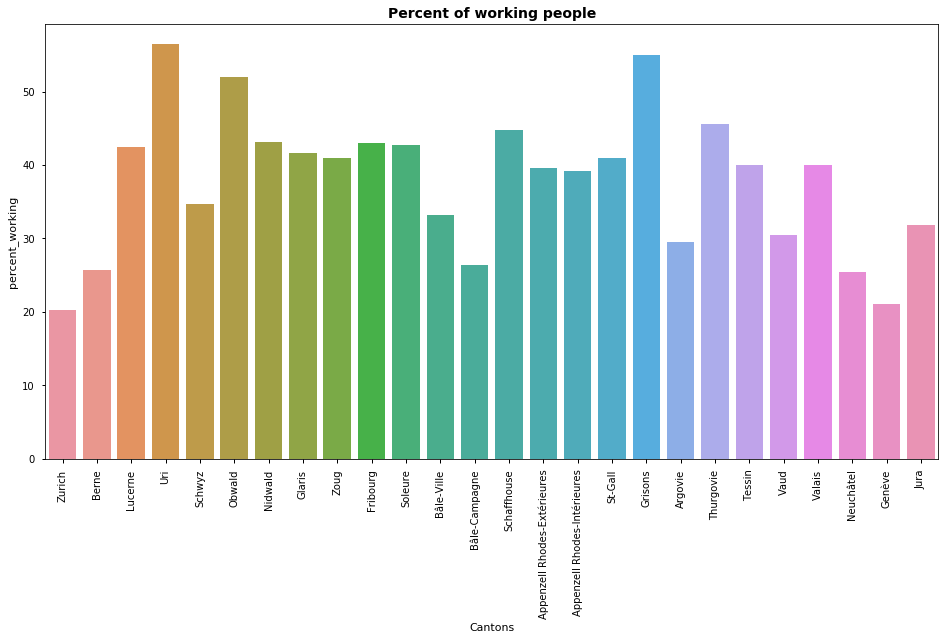

In [65]:
seaborn.set_palette("Set1")
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
result = seaborn.barplot(swiss_df["Cantons"], swiss_df["percent_working"], ax=axes)
result.set_xticklabels(swiss_df["Cantons"], rotation=90)
result.set_title("Percent of working people", fontsize=14, fontweight="bold")

The percentage is really high, especially for some cantons with more than 50% of people looking for a job already have one.
Now let's build our new percentage : 

## Question 3



Use the amstat website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between Swiss and foreign workers.

The Economic Secretary (SECO) releases a monthly report on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for foreign (5.1%) and Swiss (2.2%) workers.

Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (hint The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.


## Question 4

using the map you have just built, and the geographical information contained in it, could you give a rough estimate of the difference in unemployment rates between the areas divided by the Röstigraben?

'/home/lemni/Documents/cours/appliedDataAnalysis/git/ada-epfl'

'/home/lemni/Documents/cours/appliedDataAnalysis/git/ada-epfl'